In [11]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

DATA_PATH = "/content/drive/MyDrive/AllCars.csv"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")
df["Doors"] = pd.to_numeric(df["Doors"], errors="coerce")
df["Style"] = df["Style"].astype(str).str.strip()

df = df.dropna(subset=["Volume","Doors","Style"]).copy()
df.head()


,Make,Volume,Doors,Style
0,Toyota,102,4,Sedan
1,Kia,121,5,SUV
2,Mazda,113,4,Sedan
3,Porshe,134,5,SUV
4,Chevrolet,134,5,SUV


In [13]:
X = df[["Volume","Doors"]].to_numpy(float)

# scaling for volumes and doors
Xs = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df["ClusterID"] = kmeans.fit_predict(Xs)

# style in the cluster
cluster_style_map = df.groupby("ClusterID")["Style"].agg(lambda s: s.value_counts().index[0]).to_dict()
df["ClusterStyle"] = df["ClusterID"].map(cluster_style_map)

# Create ClusterCars.csv
cluster_cars = df[["Volume","Doors","Style","ClusterStyle"]]
cluster_cars.to_csv("ClusterCars.csv", index=False)

cluster_cars.head()


,Volume,Doors,Style,ClusterStyle
0,102,4,Sedan,Sedan
1,121,5,SUV,SUV
2,113,4,Sedan,Sedan
3,134,5,SUV,SUV
4,134,5,SUV,SUV


In [14]:
rows = []
for cid, sub in df.groupby("ClusterID"):
    cstyle = cluster_style_map[cid]
    size = len(sub)
    acc = (sub["Style"] == cstyle).sum() / size
    rows.append([cstyle, size, round(float(acc), 4)])

cluster_accuracy = pd.DataFrame(rows, columns=["ClusterStyle","SizeOfCluster","Accuracy"])
cluster_accuracy.to_csv("ClusterAccuracy.csv", index=False)

cluster_accuracy


,ClusterStyle,SizeOfCluster,Accuracy
0,SUV,9,0.5556
1,SUV,29,0.7241
2,Sedan,7,0.7143
3,SUV,31,0.5806
4,Sedan,84,0.5714


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = df[["Volume","Doors"]]
y = df["Style"]

# 80/20 split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

pred = tree.predict(X_test)
acc = accuracy_score(y_test, pred)
acc


0.625

In [16]:
tree_cars = X_test.copy()
tree_cars["Style"] = y_test.values
tree_cars["PredictedStyle"] = pred

# bottom row
tree_cars.loc[len(tree_cars)] = ["", "", "ACCURACY", round(float(acc), 4)]

tree_cars.to_csv("TreeCars.csv", index=False)
tree_cars.tail()


,Volume,Doors,Style,PredictedStyle
116,14,4,Sedan,Sedan
113,36,4,SUV,SUV
94,128,4,SUV,SUV
61,132,4,Pickup,Pickup
32,,,ACCURACY,0.625


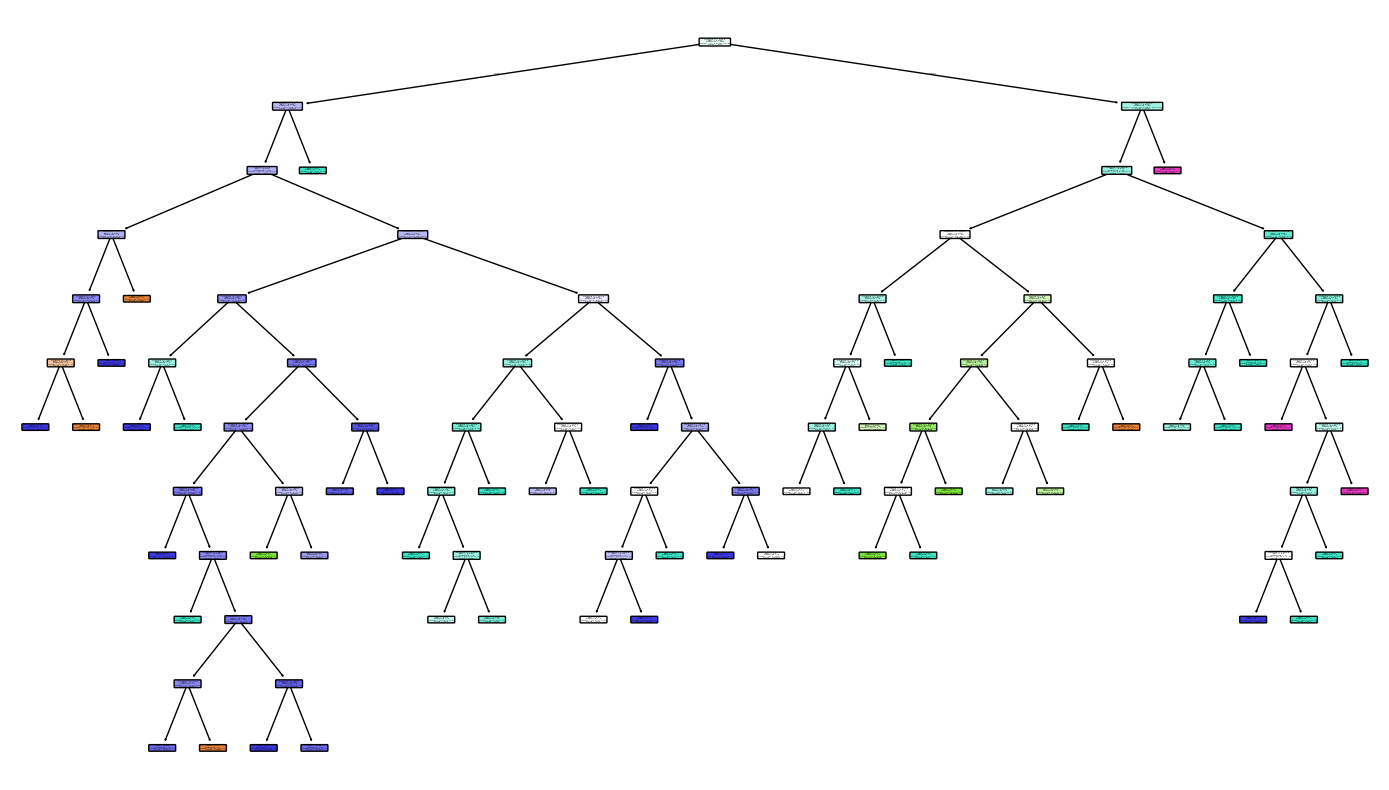

In [17]:
plt.figure(figsize=(14, 8))

plot_tree(
    tree,
    feature_names=["Volume","Doors"],
    class_names=sorted(df["Style"].unique()),
    filled=True,
    rounded=True
)

plt.tight_layout()
plt.savefig("TreeCars.png", dpi=200)
plt.show()


In [18]:
from google.colab import files
files.download("ClusterCars.csv")
files.download("ClusterAccuracy.csv")
files.download("TreeCars.csv")
files.download("TreeCars.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>